## Kaggle Notebook

In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# pytorch에서 사용할 함수들 호출하기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

In [ ]:
submission = pd.read_csv('./gender_submission.csv')
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [ ]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

In [ ]:
dataset =  pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


> ### Preprocessing

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"]

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1304        Mr
1305      Dona
1306        Mr
1307        Mr
1308    Master
Name: Title, Length: 1309, dtype: object

In [ ]:
dataset[['Survived', 'Title']].groupby(['Title']).count()

,Survived
Title,
Capt,1
Col,2
Don,1
Dona,0
Dr,7
Jonkheer,1
Lady,1
Major,2
Master,40


In [ ]:
class TitleSelector(BaseEstimator, TransformerMixin):
    def __init__( self):
        self.dict_title = {
            "Capt":0,
            "Col":0,
            "Don":0,
            "Dona":0,
            "Dr":4,
            "Jonkheer":0,
            "Lady":0,
            "Major":0,
            "Master":4,
            "Miss":2,
            "Mlle":0,
            "Mme":0,
            "Mr":1,
            "Mrs":3,
            "Ms":0,
            "Rev":0,
            "Sir":0,
            "the Countess":0
        }

    def fit(self, X, y=None):
        return self

    def transform( self, X, y=None):
        for i, name in enumerate(X["Name"]):
            for title in self.dict_title.keys():
                if title in name:
                    X["Name"][i] = self.dict_title[title]
                    break

            assert X["Name"][i] in self.dict_title.values()

        return X

name_transformer = Pipeline(steps=[
    ('name', TitleSelector()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

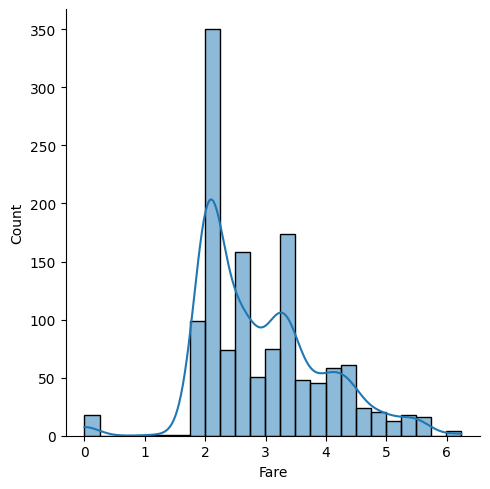

In [ ]:
g = sns.displot(dataset["Fare"][(dataset["Fare"].notnull())], kde=True)

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,Mr


In [ ]:
dataset = dataset.drop(['Title'], axis=1)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S


In [ ]:
num_cols = ["Age", "Fare"]
cat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"]
cols = num_cols + cat_cols + ["Name"]


preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('name', name_transformer, ["Name"]),
    ('cat', categorical_transformer, cat_cols),
])

X_train = preprocessor.fit_transform(df_train[cols])
y_train = df_train["Survived"].values

In [ ]:
X_train.shape

(891, 856)

In [ ]:
X_test = preprocessor.transform(df_test[cols])
X_test.shape

(418, 856)

### Dataset, DataLoader

In [ ]:
#교차 검증
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
X_trn.toarray().shape

(801, 856)

In [ ]:
X_test

<418x856 sparse matrix of type '<class 'numpy.float64'>'
	with 3779 stored elements in Compressed Sparse Row format>

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = torch.from_numpy(x.toarray()).to(torch.float)
        if type(y) != type(None):
            self.y = torch.from_numpy(y).to(torch.float)
        else:
            self.y = None

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index] if type(self.y) != type(None) else 0

    def __len__(self):
        return self.x.shape[0]

In [ ]:
train_dataset = CustomDataset(X_trn, y_trn)
valid_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

### modeling

In [ ]:
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(856, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(0.8),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.Dropout(0.8),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Dropout(0.8),


            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
model = TitanicModel()

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = StepLR(optimizer, step_size=20, gamma=0.7)

### Training

In [ ]:
# 모델 학습
epochs = 100
dry_run = False # 1 배치만 훈련

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = 0
    correct =0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        # print(output)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().sum()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('Train Epoch: {}/{}\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, epochs, train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    if dry_run:
        break

    # 테스트
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:
        with torch.no_grad():
            output = model(data)
        test_loss += criterion(output, target.view(-1, 1)).detach().sum()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)

    print('Valid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

    scheduler.step()

Train Epoch: 1/100	Loss: 0.021636	 Accuracy: 489/801 (61%)
Valid set: Average loss: 0.0206, Accuracy: 60/90 (67%)

Train Epoch: 2/100	Loss: 0.020812	 Accuracy: 489/801 (61%)
Valid set: Average loss: 0.0203, Accuracy: 60/90 (67%)

Train Epoch: 3/100	Loss: 0.020826	 Accuracy: 488/801 (61%)
Valid set: Average loss: 0.0201, Accuracy: 60/90 (67%)

Train Epoch: 4/100	Loss: 0.019876	 Accuracy: 489/801 (61%)
Valid set: Average loss: 0.0186, Accuracy: 60/90 (67%)

Train Epoch: 5/100	Loss: 0.019509	 Accuracy: 488/801 (61%)
Valid set: Average loss: 0.0177, Accuracy: 60/90 (67%)

Train Epoch: 6/100	Loss: 0.019330	 Accuracy: 488/801 (61%)
Valid set: Average loss: 0.0176, Accuracy: 60/90 (67%)

Train Epoch: 7/100	Loss: 0.019287	 Accuracy: 488/801 (61%)
Valid set: Average loss: 0.0170, Accuracy: 60/90 (67%)

Train Epoch: 8/100	Loss: 0.017775	 Accuracy: 488/801 (61%)
Valid set: Average loss: 0.0154, Accuracy: 60/90 (67%)

Train Epoch: 9/100	Loss: 0.017682	 Accuracy: 488/801 (61%)
Valid set: Average lo

### Prediction

In [ ]:
predictions = []
for data, _ in test_loader:
    with torch.no_grad():
        output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    predictions += pred.reshape(-1).tolist()


In [ ]:
df_pred = pd.DataFrame(df_test["PassengerId"])
df_pred["Survived"] = predictions
df_pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
df_pred.to_csv("submission.csv", index=False)